<a href="https://colab.research.google.com/github/karlmaji/pytorch_learning/blob/master/ResNeXt50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install einops

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,random_split
import os
import numpy as np
import pandas as pd
from einops import rearrange,reduce,repeat
from einops.layers.torch import EinMix as Mix
from einops.layers.torch import Rearrange,Reduce
import random

def set_seed(seed):
  np.random.seed(seed)
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():  # GPU operation have separate seed
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


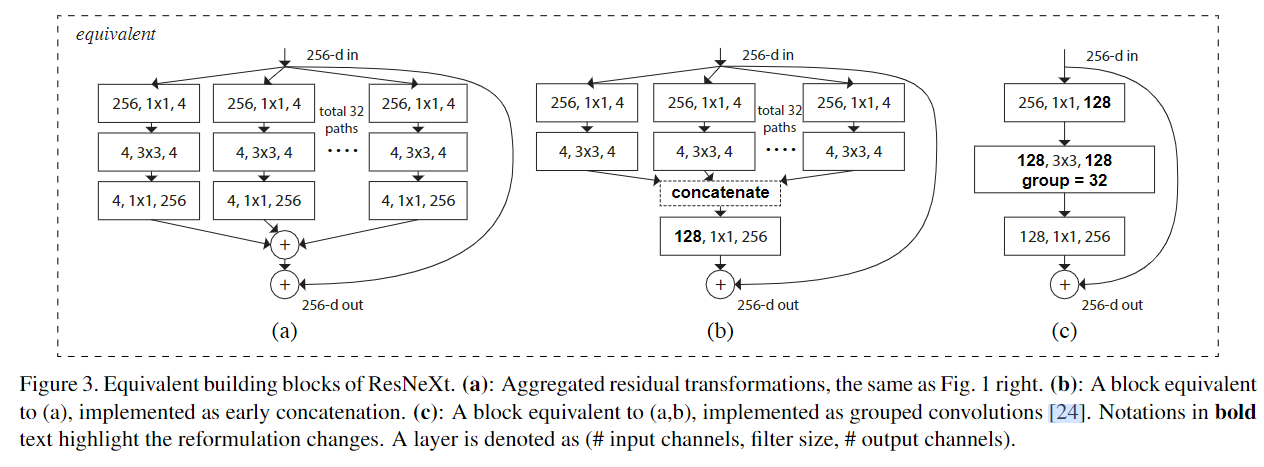

In [18]:
class ResNextBolck(nn.Module):
  def __init__(self,input_channel,bottleneck_dim,output_channel,stride=1):
    super(ResNextBolck,self).__init__()
    bottleneck_channel = bottleneck_dim
    self.bottleneck = nn.Sequential(
        nn.Conv2d(input_channel,bottleneck_channel,(1,1),bias=False),
        nn.BatchNorm2d(bottleneck_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(bottleneck_channel,bottleneck_channel,(3,3),stride=stride,padding=1,bias=False,groups=32),
        nn.BatchNorm2d(bottleneck_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(bottleneck_channel,output_channel,(1,1),bias=False),
        nn.BatchNorm2d(output_channel),
    )
    if stride==2:
      self.down_sample = nn.Sequential(
          nn.Conv2d(input_channel,output_channel,(1,1),stride=stride,bias=False),
          nn.BatchNorm2d(output_channel)
      )
    else:
      self.down_sample = nn.Identity()
  def forward(self,x):
    x = F.relu(self.bottleneck(x) + self.down_sample(x),inplace=True)
    return x

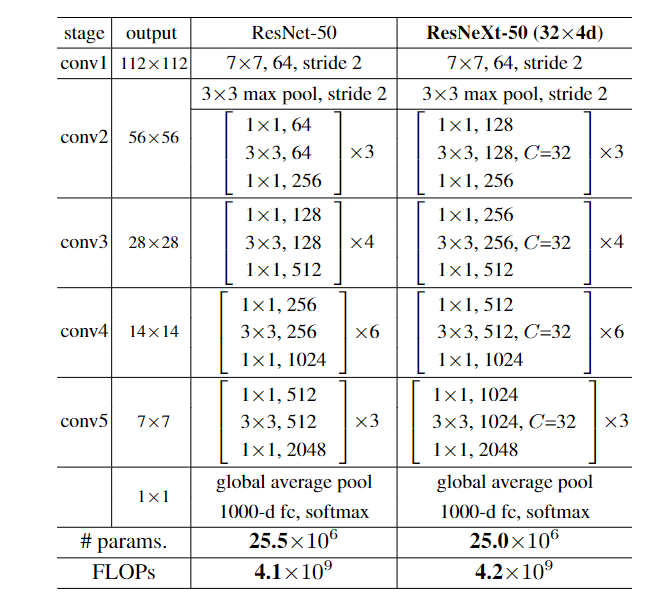

In [23]:
z = nn.Conv2d(3,64,(7,7),stride=2,padding=3,bias=False)
x =torch.randn(3,3,224,224)
z(x).shape

torch.Size([3, 64, 112, 112])

In [28]:
class ResNext50(nn.Module):
  def __init__(self,input_channel,num_class):
    super(ResNext50,self).__init__()
    channel_list =[64,128,256,512,1024,2048]
    self.begin =nn.Sequential(
        nn.Conv2d(input_channel,channel_list[0],(7,7),stride=2,padding=3,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d((3,3),stride=2,padding=1),
    )
    self.conv2 = nn.Sequential(
        ResNextBolck(channel_list[0],channel_list[1],channel_list[2],2),
        *[ResNextBolck(channel_list[2],channel_list[1],channel_list[2],1) for i in range(2)]

    )
    self.conv3 = nn.Sequential(
        ResNextBolck(channel_list[2],channel_list[2],channel_list[3],2),
        *[ResNextBolck(channel_list[3],channel_list[2],channel_list[3],1) for i in range(3)]

    )
    self.conv4 = nn.Sequential(
        ResNextBolck(channel_list[3],channel_list[3],channel_list[4],2),
        *[ResNextBolck(channel_list[4],channel_list[3],channel_list[4],1) for i in range(5)]

    )
    self.conv5 = nn.Sequential(
        ResNextBolck(channel_list[4],channel_list[4],channel_list[5],2),
        *[ResNextBolck(channel_list[5],channel_list[4],channel_list[5],1) for i in range(2)]

    )
    self.head = nn.Linear(channel_list[-1],num_class)
  def forward(self,x):
    x = self.begin(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.head(x.mean([-1,-2]))
    return x


In [29]:
model = ResNext50(3,1000)
x=torch.randn(3,3,224,224)
model(x).shape

torch.Size([3, 1000])

In [30]:
import torchvision
resnext = torchvision.models.resnext50_32x4d()


In [32]:
total_param_ours = []
for name,param in model.named_parameters():
  total_param_ours+=[np.prod(param.size())]
print(f"我们的模型总参数量为:{sum(total_param_ours)}")

total_param_official = []
for name,param in resnext.named_parameters():
  total_param_official+=[np.prod(param.size())]
print(f"pytorch官方的模型总参数量为:{sum(total_param_official)}")
print(f"参数个数{len(total_param_ours)},{len(total_param_official)}")

我们的模型总参数量为:25028904
pytorch官方的模型总参数量为:25028904
参数个数161,161
